In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]



One of the reviewers is worried about how our observations that many genes only have one transcript 
called might be affected by sequencing depth. To double check this, we'll take the library that the reviewer called out, and ask how often transcripts that only had one transcript in this library also have only one transcript in replicates for the same sample * condition, as well as from the same sample type (brain).

In [10]:
ca = cerberus.read(m_cerberus_h5)
sg = swan.read(m_swan_file)
filt_ab_df = pd.read_csv(m_filt_ab, sep='\t')
obs_col = 'dataset'
min_tpm = 1
dataset = 'cortex_14d_f_1'

Read in graph from ../../proc_revisions/data/mouse/lr/swan/swan_graph.p


In [5]:
# library-level observed triplets
df = ca.get_expressed_triplets(sg,
                               obs_col=obs_col,
                               min_tpm=min_tpm,
                               source='dataset_det')

In [20]:
# get just the stuff with cortex_14d_f_1
subset_df = df.loc[df.dataset==dataset].copy(deep=True)
subset_df.head()

# which genes only had one isoform?
gids = subset_df.loc[subset_df.n_iso==1, 'gid'].tolist()

In [27]:
# now get the gene triplets for the entire sample
# (expressed genes from any replicate; ie higher sampling depth)
meta = pd.read_csv(m_lib_meta, sep='\t')
sample = meta.loc[meta.dataset == dataset, 'sample'].values[0]

rep_df = ca.triplets.loc[ca.triplets['sample'] == sample].copy(deep=True)

In [30]:
# limit to the gids where we only had one isoform in the lowly-sequenced library
print(len(rep_df.index))
rep_df = rep_df.loc[rep_df.gid.isin(gids)]
print(len(rep_df.index))

# count the genes that still have 1 transcript / gene and those that now have more 
# when upscaling like this
rep_df = rep_df[['gid', 'n_iso']].groupby('n_iso').count().reset_index().rename({'gid':'n_genes'}, axis=1)
rep_df.head()

30506
7976


,n_iso,n_genes
0,1.0,5182
1,2.0,1814
2,3.0,643
3,4.0,215
4,5.0,87


In [34]:
rep_df['n_iso'] = rep_df.n_iso.astype('int')

[Text(0.5, 0, '# transcripts / gene'), Text(0, 0.5, '# genes')]

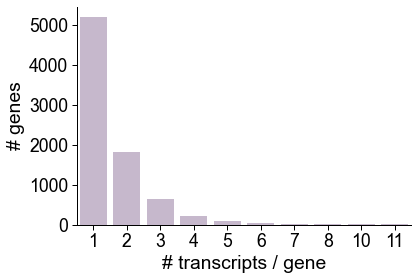

In [36]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

c_dict, order = get_biosample_colors(species='mouse')
c = c_dict[sample]
ax = sns.barplot(data=rep_df, x='n_iso', y='n_genes', color=c)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel='# transcripts / gene', ylabel='# genes')

In [38]:
n_1 = rep_df.loc[rep_df.n_iso==1, 'n_genes'].values[0]
n_more = rep_df.loc[rep_df.n_iso!=1, 'n_genes'].sum(axis=0)
n_num = n_1
n = n_1+n_more
print('{:.2f}% ({}/{}) of genes w/ 1 isoform from {} still have 1 isoform in entire {} sample * condition'.format((n_num/n)*100, n_num, n, dataset, sample))

64.97% (5182/7976) of genes w/ 1 isoform from cortex_14d_f_1 still have 1 isoform in entire cortex_14d sample * condition


In [49]:
# how many more reads did we gain when we looked at entire sample versus just this one dataset?
meta = pd.read_csv(m_lib_meta, sep='\t')
n_reads = meta.loc[meta.dataset==dataset, 'reads_post_talon'].values[0]
n_reads_tot = meta.loc[meta['sample']==sample, 'reads_post_talon'].sum(axis=0)
print(n_reads)
print(n_reads_tot)
print(n_reads_tot-n_reads)

1087280
3567229
2479949
